##Binary


In [3]:
import numpy as np
import pandas as pd
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
from datasets import load_dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
dataset = load_dataset('ade_corpus_v2','Ade_corpus_v2_classification')

Generating train split:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [ ]:
dataset['train']['text'][:10]

['Intravenous azithromycin-induced ototoxicity.',
 "Immobilization, while Paget's bone disease was present, and perhaps enhanced activation of dihydrotachysterol by rifampicin, could have led to increased calcium-release into the circulation.",
 'Unaccountable severe hypercalcemia in a patient treated for hypoparathyroidism with dihydrotachysterol.',
 'METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.',
 'METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.',
 'Naproxen, the most common offender, has been associated with a dimorphic clinical pattern: a PCT-like presentation and one simulating erythropoietic protoporphyria in the pediatric population.',
 'RESULTS: A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.',
 'RESULTS: A 44-year-old man taking naproxen for chr

In [ ]:
dataset['train']['label'][:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
df=dataset['train'].to_pandas()
df.head()

,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1


In [ ]:
X,y=df['text'],df['label']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

93


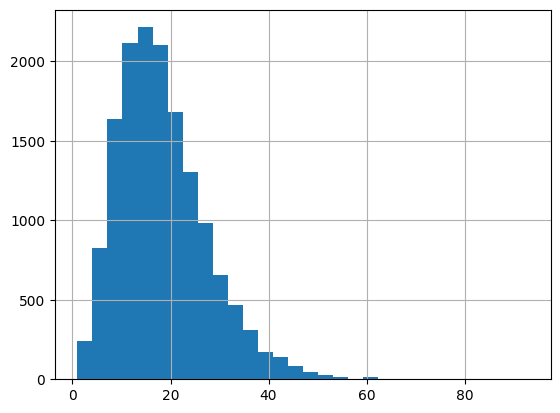

In [ ]:
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [ ]:
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())
print("train_y:",train_y)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())
print("val_y:",val_y)

train_y: tensor([0, 0, 0,  ..., 0, 0, 0])
val_y: tensor([1, 0, 0,  ..., 0, 0, 0])


In [ ]:
train_seq

tensor([[  101,  2011,  1996,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  5107,  9353,  ...,     0,     0,     0],
        ...,
        [  101,  2044,  3169,  ...,     0,     0,     0],
        [  101, 15306,  1024,  ...,     0,     0,     0],
        [  101,  1996, 10947,  ...,     0,     0,     0]])

In [ ]:
batch_size = 16
train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu =  nn.ReLU()

        self.fc1 = nn.Linear(768,384)

        self.fc2 = nn.Linear(384,2)

        self.f = nn.Sigmoid()

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.f(x)
        return x

In [ ]:
model = BERT_Arch(bert)
model = model.to(device)

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight(class_weight='balanced', y = y_train, classes = np.unique(y_train))
print(class_wts)

[0.70315858 1.73056578]


In [ ]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [ ]:
cross_entropy  = nn.CrossEntropyLoss(weight=weights)
epochs = 8

In [28]:
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    total_preds=[]
    total_labels =[]

    for step,batch in enumerate(train_dataloader):

        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch


        model.zero_grad()

        preds = model(sent_id, mask)

        loss = cross_entropy(preds, labels)

        total_loss = total_loss + loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)



        total_preds+=list(preds)
        total_labels+=labels.tolist()

    avg_loss = total_loss / len(train_dataloader)

    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [29]:
def evaluate():

    print("\nEvaluating...")


    model.eval()

    total_loss, total_accuracy = 0, 0


    total_preds = []
    total_labels = []
    for step,batch in enumerate(val_dataloader):

        if step % 30 == 0 and not step == 0:

          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        with torch.no_grad():

            preds = model(sent_id, mask)

            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    avg_loss = total_loss / len(val_dataloader)

    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [30]:
def save_checkpoint(filename, epoch, model, optimizer):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer}
    torch.save(state, filename)

In [ ]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, f1_train = train()

    valid_loss, f1_valid = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'topic_saved_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 8
  Batch   100  of    941.
  Batch   200  of    941.
  Batch   300  of    941.
  Batch   400  of    941.
  Batch   500  of    941.
  Batch   600  of    941.
  Batch   700  of    941.
  Batch   800  of    941.
  Batch   900  of    941.

Evaluating...
  Batch    30  of    236.
  Batch    60  of    236.
  Batch    90  of    236.
  Batch   120  of    236.
  Batch   150  of    236.
  Batch   180  of    236.
  Batch   210  of    236.

Training Loss: 0.614
Validation Loss: 0.600

Training F1: 0.682
Validation F1: 0.586

 Epoch 2 / 8
  Batch   100  of    941.
  Batch   200  of    941.
  Batch   300  of    941.
  Batch   400  of    941.
  Batch   500  of    941.
  Batch   600  of    941.
  Batch   700  of    941.
  Batch   800  of    941.
  Batch   900  of    941.

Evaluating...
  Batch    30  of    236.
  Batch    60  of    236.
  Batch    90  of    236.
  Batch   120  of    236.
  Batch   150  of    236.
  Batch   180  of    236.
  Batch   210  of    236.

Training Loss: 0.567
Va

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
path = 'topic_saved_weights.pt'
test_df = pd.concat([X_test, y_test], axis=1)[:1000]

checkpoint = torch.load(path,map_location=device)
model = checkpoint.get("model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


test_text,test_labels = test_df["text"],test_df["label"]

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       712
           1       0.72      0.73      0.73       288

    accuracy                           0.84      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.84      0.84      0.84      1000



In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

##Multiclass



In [9]:
train=pd.read_csv('train.txt',sep=';',header=0,names=['text','label'])
test=pd.read_csv('test.txt',sep=';',header=0,names=['text','label'])
val=pd.read_csv('val.txt',sep=';',header=0,names=['text','label'])

In [10]:
train.head()

,text,label
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness


In [11]:
X_train,y_train=train['text'],train['label']
X_test,y_test=test['text'],test['label']
X_val,y_val=val['text'],val['label']

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

66


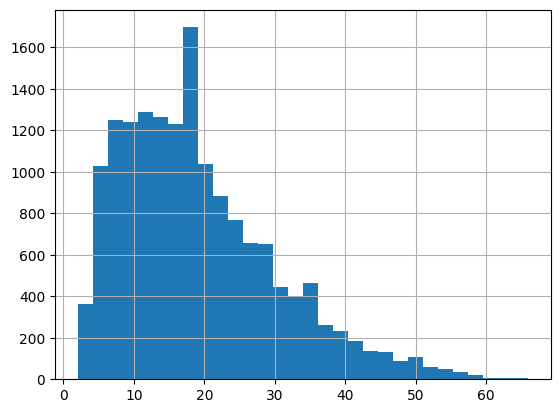

In [13]:
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [14]:
dict={}
lst=y_test.unique()
for i in range(0,6):
  dict[lst[i]]=i

In [15]:
y_train.head()

0    sadness
1      anger
2       love
3      anger
4    sadness
Name: label, dtype: object

In [16]:
y_train=y_train.replace(dict)
y_train.head()

0    0
1    3
2    4
3    3
4    0
Name: label, dtype: int64

In [17]:
y_test=y_test.replace(dict)
y_val=y_val.replace(dict)

In [18]:
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())
print("train_y:",train_y)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())
print("val_y:",val_y)

train_y: tensor([0, 3, 4,  ..., 1, 3, 0])
val_y: tensor([0, 4, 3,  ..., 1, 1, 1])


In [20]:
batch_size = 16
train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [21]:
for param in bert.parameters():
    param.requires_grad = False

In [22]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu =  nn.ReLU()

        self.fc1 = nn.Linear(768,384)

        self.fc2 = nn.Linear(384,6)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.softmax(x)
        return x

In [23]:
model = BERT_Arch(bert)

model = model.to(device)

In [24]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight(class_weight='balanced', y = y_train, classes = np.unique(y_train))
print(class_wts)

[0.571597   0.49729579 1.37661332 1.23506253 2.04486196 4.66171329]


In [35]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

cross_entropy  = nn.CrossEntropyLoss(weight=weights)

epochs = 40

In [36]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, f1_train = train()

    valid_loss, f1_valid = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'topic_saved_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 40
  Batch   100  of  1,000.
  Batch   200  of  1,000.
  Batch   300  of  1,000.
  Batch   400  of  1,000.
  Batch   500  of  1,000.
  Batch   600  of  1,000.
  Batch   700  of  1,000.
  Batch   800  of  1,000.
  Batch   900  of  1,000.

Evaluating...
  Batch    30  of    125.
  Batch    60  of    125.
  Batch    90  of    125.
  Batch   120  of    125.

Training Loss: 1.640
Validation Loss: 1.640

Training F1: 0.423
Validation F1: 0.439

 Epoch 2 / 40
  Batch   100  of  1,000.
  Batch   200  of  1,000.
  Batch   300  of  1,000.
  Batch   400  of  1,000.
  Batch   500  of  1,000.
  Batch   600  of  1,000.
  Batch   700  of  1,000.
  Batch   800  of  1,000.
  Batch   900  of  1,000.

Evaluating...
  Batch    30  of    125.
  Batch    60  of    125.
  Batch    90  of    125.
  Batch   120  of    125.

Training Loss: 1.641
Validation Loss: 1.640

Training F1: 0.422
Validation F1: 0.439

 Epoch 3 / 40
  Batch   100  of  1,000.
  Batch   200  of  1,000.
  Batch   300  of  1,000.

KeyboardInterrupt: ignored

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()
path = 'topic_saved_weights.pt'
test_df = pd.concat([X_test, y_test], axis=1)[:1000]

checkpoint = torch.load(path,map_location=device)
model = checkpoint.get("model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


test_text,test_labels = test_df["text"],test_df["label"]

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [38]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [39]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.56      0.39      0.46       294
           1       0.71      0.44      0.54       338
           2       0.34      0.61      0.44       115
           3       0.38      0.37      0.38       140
           4       0.18      0.48      0.26        83
           5       0.08      0.03      0.05        30

    accuracy                           0.43      1000
   macro avg       0.37      0.39      0.35      1000
weighted avg       0.51      0.43      0.44      1000

